# 16's place solution

This kenel based on https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-inference My model's weights trained with this code https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-training-colab

In [1]:
!nvidia-smi

Fri Jun  4 17:36:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
try:
    import resnest
except ModuleNotFoundError:
    !pip install -q "../input/resnest50-fast-package/resnest-0.0.6b20200701/resnest"

In [3]:
!pip install ../input/timm-pytorch-image-models/pytorch-image-models-master/
!pip install ../input/torchlibrosa/torchlibrosa-0.0.5-py3-none-any.whl

Processing /kaggle/input/timm-pytorch-image-models/pytorch-image-models-master
  Created wheel for timm: filename=timm-0.4.11-py3-none-any.whl size=372536 sha256=a8f6ceb98ec3d5d944f3a63125e06e6e6203b8f3418669ae2d30eb107a68b46e
  Stored in directory: /root/.cache/pip/wheels/b2/4e/24/ca2e6fc7fceb1e8f1f4d3e5dd21df64327a03cf318d915c1bb
Successfully built timm
Processing /kaggle/input/torchlibrosa/torchlibrosa-0.0.5-py3-none-any.whl


In [4]:
!pip install ../input/pytorchlightning/tensorboard-2.2.0-py3-none-any.whl ../input/pytorchlightning/pytorch_lightning-0.9.0-py3-none-any.whl

Processing /kaggle/input/pytorchlightning/tensorboard-2.2.0-py3-none-any.whl
Processing /kaggle/input/pytorchlightning/pytorch_lightning-0.9.0-py3-none-any.whl
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.2.5
    Uninstalling pytorch-lightning-1.2.5:
      Successfully uninstalled pytorch-lightning-1.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires tensorboard~=2.4, but you have tensorboard 2.2.0 which is incompatible.
tensorflow-cloud 0.1.13 requires tensorboard>=2.3.0, but you have tensorboard 2.2.0 which is incompatible.


In [5]:
!pip install ../input/torchaudiomentations070/torch_audiomentations-0.7.0-py3-none-any.whl 

Processing /kaggle/input/torchaudiomentations070/torch_audiomentations-0.7.0-py3-none-any.whl


In [6]:
import numpy as np
import librosa
import soundfile as sf
import pandas as pd
import cv2
from pathlib import Path
import re

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import torchaudio

from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation

import timm
from contextlib import contextmanager
from typing import Optional
import warnings

import audioread
import logging
import random

import os
import json

from tqdm.notebook import tqdm

import time
from resnest.torch import resnest50

from albumentations.core.transforms_interface import ImageOnlyTransform

import joblib

import gc

from sklearn.metrics import label_ranking_average_precision_score

import pytorch_lightning as pl

import torch_audiomentations as AA

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [7]:
torch.__version__

'1.7.0'

# Configs

In [8]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 5
THRESH = 0.25


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

TEST_AUDIO_ROOT = Path("../input/birdclef-2021/test_soundscapes")
SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
PUBLIC = False
#TARGET_PATH = None
    
if not len(list(TEST_AUDIO_ROOT.glob("*.ogg"))):
    TEST_AUDIO_ROOT = Path("../input/birdclef-2021/train_soundscapes")
    SAMPLE_SUB_PATH = None
    # SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
    PUBLIC = True
    
TARGET_PATH = Path("../input/birdclef-2021/train_soundscape_labels.csv")

DEVICE: cuda


# Data

## Transform audio ogg to melspec npy 

In [9]:
data = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in TEST_AUDIO_ROOT.glob("*.ogg")],
    columns = ["filename", "id", "site", "date", "filepath"]
)
print(data.shape)
data.head()

(20, 5)


,filename,id,site,date,filepath
0,20152_SSW_20170805,20152,SSW,20170805,../input/birdclef-2021/train_soundscapes/20152...
1,57610_COR_20190904,57610,COR,20190904,../input/birdclef-2021/train_soundscapes/57610...
2,7843_SSW_20170325,7843,SSW,20170325,../input/birdclef-2021/train_soundscapes/7843_...
3,42907_SSW_20170708,42907,SSW,20170708,../input/birdclef-2021/train_soundscapes/42907...
4,7019_COR_20190904,7019,COR,20190904,../input/birdclef-2021/train_soundscapes/7019_...


In [10]:
public_data = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path("../input/birdclef-2021/train_soundscapes").glob("*.ogg")],
    columns = ["filename", "id", "site", "date", "filepath"]
)
print(data.shape)
data.head()

(20, 5)


,filename,id,site,date,filepath
0,20152_SSW_20170805,20152,SSW,20170805,../input/birdclef-2021/train_soundscapes/20152...
1,57610_COR_20190904,57610,COR,20190904,../input/birdclef-2021/train_soundscapes/57610...
2,7843_SSW_20170325,7843,SSW,20170325,../input/birdclef-2021/train_soundscapes/7843_...
3,42907_SSW_20170708,42907,SSW,20170708,../input/birdclef-2021/train_soundscapes/42907...
4,7019_COR_20190904,7019,COR,20190904,../input/birdclef-2021/train_soundscapes/7019_...


In [11]:
!rm -rf test_data_1 
!mkdir test_data_1 
TARGET_AUDIO_1 = Path("test_data_1")


In [12]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin=0, fmax=16000, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = librosa.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = librosa.power_to_db(melspec).astype(np.float32)
        return melspec

In [13]:
import math
def load_audio(record, sr=32000, root=Path("./")):
    waveform, sample_rate = torchaudio.load(
        root.joinpath(record).with_suffix(".ogg").as_posix(),
    )
    if sample_rate != sr:
        y = torchaudio.transforms.Resample(sample_rate, sr)(waveform)
        return y
    else:
        return waveform

sound_len = 5 * 32000

do_melspec_1 = MelSpecComputer(sr=32000, n_mels=128)

#Тестовый файл нарезается на фрагменты, длинною sound_len, 
def load_and_save_test(row):
   # try:
        y = load_audio(row["filepath"], 32000)
        y = y.squeeze()
        len_y = len(y)
        #print(row["t_min"], row["t_max"])
        #print(len_y)

        for i in range(math.ceil(len(y) / sound_len)):
            t_min = max(i * sound_len - 32000 , 0)
            t_max = min((i +1) * sound_len + 32000, len_y)
            #print(t_min, t_max)
            labl = np.array(y[int(t_min):int(t_max)])#.view(1,-1)
            if len(labl) < (7 * 32000):
                labl = np.hstack([labl, labl])[:(7 * 32000)]
            #print(len(labl))
            
            np.save(TARGET_AUDIO_1/("_".join(row["filename"].split("_")[:2] + [str((i+1)*5)])+".npy"), do_melspec_1(labl), allow_pickle=True)
            

for n, row in tqdm(data.iterrows(), total=data.shape[0]):
    load_and_save_test(row)

if PUBLIC:
    pass
else:
    for n, row in tqdm(public_data.iterrows(), total=public_data.shape[0]):
        load_and_save_test(row)

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
# import IPython
# IPython.display.Audio("test_data/11254_COR_10.ogg")

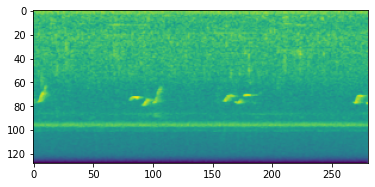

In [15]:
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(np.load("test_data_1/11254_COR_10.npy"))

## Use data in models

In [16]:
def normalize(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def mono_to_color(image):
    image = image.astype("float32", copy=False) / 255.0
    image = np.stack([image, image, image])
    return image

def crop_or_pad(y, length):
    if len(y) < length:
        y = np.concatenate([y, length - np.zeros(len(y))])
    elif len(y) > length:
        y = y[:length]
    return y

In [17]:
apply_augmentation = AA.Compose(
    transforms=[
        AA.Gain(
            min_gain_in_db=-5.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        AA.AddColoredNoise(p = 0.9, min_f_decay=0,  max_f_decay=1, 
                           min_snr_in_db=5,  max_snr_in_db = 20, sample_rate = 32000), # white, pink noise
        AA.Shift(p=0.2, min_shift=-0.2, max_shift=0.2, sample_rate = 32000),
    ]
)

In [18]:
class BirdCLEFDataset(Dataset):
    def __init__(self, data, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=None, res_type="kaiser_fast", resample=True, transform = False):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample
        self.transform = transform

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
    def __len__(self):
        return len(self.data)
    

    
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
        image = self.normalize(image)
        return image

    def read_file(self, filepath):
        audio, orig_sr = sf.read(filepath, dtype="float32")

        if self.resample and orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        audios = []
        for i in range(self.audio_length, len(audio) + self.step, self.step):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
            
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        return images
    def read_ready_file(self, filename):
        audios = []
        i = 0
        fname = "_".join(filename.split("_")[:2] + [str((i+1)*5)])+".npy"
        all_files = os.listdir(TARGET_AUDIO_1)
        while fname in all_files:
            melspec = np.load(TARGET_AUDIO_1/fname)
            image = np.nan_to_num(normalize(melspec)) 
            image = mono_to_color(image)
            if self.transform:
                image = apply_augmentation(torch.Tensor(image))
 
            #print(fname)
            audios.append(image)
            
            i+=1
            fname = "_".join(filename.split("_")[:2] + [str((i+1)*5)])+".npy"
        return np.stack(audios)
            
    def __getitem__(self, idx):
        return self.read_ready_file(self.data.loc[idx, "filename"])

In [19]:
df_train = pd.read_csv("../input/birdclef-2021/train_metadata.csv")

LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df_train["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}

# Inference

In [20]:
test_data = BirdCLEFDataset(data=data)
len(test_data), test_data[3].shape

(20, (120, 3, 128, 281))

In [21]:
def load_net(checkpoint_path, num_classes=NUM_CLASSES):
    #net = resnest50(pretrained=False)
    net = timm.create_model('resnest50d', pretrained = False)
    #print(net)
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(DEVICE)
    net = net.eval()
    return net

def load_net2(checkpoint_path, num_classes=NUM_CLASSES):
    #net = resnest50(pretrained=False)
    net = timm.create_model('resnest50d_4s2x40d', pretrained = False)
    #print(net)
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)['state_dict']
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(DEVICE)
    net = net.eval()
    return net

In [22]:

nets = [
    load_net(Path("../input/kkiller-birdclef-models-public/birdclef_resnest50_fold0_epoch_10_f1_val_06471_20210417161101.pth").as_posix()),
    #Path("../input/hpa-mw2/birdclef_resnest50d_fold0_epoch_09_f1_val_07535_20210518114548.pth"),
    #Path("../input/hpa-mw2/resnest50d_4s2x40d-epoch4-val_loss0.023-val_f10.619.ckpt")
    load_net2(Path("../input/birdclef-for-nadya/resnest50d_4s2x40d-epoch11-val_loss0.022-val_f10.730.ckpt").as_posix())
]



In [23]:
@torch.no_grad()
def get_thresh_preds(out, thresh=None):
    thresh = thresh or THRESH
    o = (-out).argsort(1)
    npreds = (out > thresh).sum(1)
    preds = []
    for oo, npred in zip(o, npreds):
        preds.append(oo[:npred].cpu().numpy().tolist())
    return preds

In [24]:
def get_bird_names(preds):
    bird_names = []
    for pred in preds:
        if not pred:
            bird_names.append("nocall")
        else:
            bird_names.append(" ".join([INV_LABEL_IDS[bird_id] for bird_id in pred]))
    return bird_names

In [25]:
def predict(nets, test_data, names=True):
    preds = []
    with torch.no_grad():
        for idx in  tqdm(list(range(len(test_data)))):
            xb = torch.from_numpy(test_data[idx]).to(DEVICE)
            pred = 0.
            for net in nets:
                o = net(xb)
                o = torch.sigmoid(o)

                pred += o

            pred /= len(nets)
            
            if names:
                pred = get_bird_names(get_thresh_preds(pred))

            preds.append(pred)
    return preds

In [26]:
def preds_as_df(data, preds):
    sub = {
        "row_id": [],
        "birds": [],
    }
    
    for row, pred in zip(data.itertuples(False), preds):
        row_id = [f"{row.id}_{row.site}_{5*i}" for i in range(1, len(pred)+1)]
        sub["birds"] += pred
        sub["row_id"] += row_id
        
    sub = pd.DataFrame(sub)
    
    if SAMPLE_SUB_PATH:
        sample_sub = pd.read_csv(SAMPLE_SUB_PATH, usecols=["row_id"])
        sub = sample_sub.merge(sub, on="row_id", how="left")
        sub["birds"] = sub["birds"].fillna("nocall")
    return sub

In [27]:
pred_probas = predict([nets[0]], test_data, names=False)
print(len(pred_probas))
preds = [get_bird_names(get_thresh_preds(pred, thresh=0.1)) for pred in pred_probas]
sub = preds_as_df(data, preds)
print(sub.shape)
sub.to_csv("submission_1_0.csv", index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

20
(2400, 2)


In [28]:
pred_probas = predict([nets[1]], test_data, names=False)
print(len(pred_probas))
preds = [get_bird_names(get_thresh_preds(pred, thresh=0.4)) for pred in pred_probas]
sub = preds_as_df(data, preds)
print(sub.shape)
sub.to_csv("submission_1_1.csv", index=False)


  0%|          | 0/20 [00:00<?, ?it/s]

20
(2400, 2)


In [29]:
del sub

In [30]:
gc.collect()

197

## Filter by location

In [31]:
from sklearn import preprocessing
lb = preprocessing.MultiLabelBinarizer()
lb = joblib.load("../input/birdclef-for-nadya/labelbinarizer_3.joblib")

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
clf = OneVsRestClassifier(LogisticRegression(random_state=1812, solver="saga", class_weight="balanced", max_iter=100, C=1291.54966501), n_jobs=-1)
clf = joblib.load("../input/birdclef-for-nadya/classifier_3.joblib")

def get_month(x):
    date = x.split("-")
    if len(date) > 1:
        return date[1]
    else:
        return None
df_train["month"] = df_train["date"].astype(str).apply(lambda x: get_month(x))
df_train.dropna(inplace=True)

sc = preprocessing.StandardScaler()
sc.fit(df_train[[ 'latitude', 'longitude','month']].astype(float).to_numpy())

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or 

StandardScaler()

In [32]:
locs = {}
print(data["site"].unique())
for loc in data["site"].unique():
    with open(Path("../input/birdclef-2021/test_soundscapes")/(loc + "_recording_location.txt"), "r") as f:
        row = {}
        for line in f:
            line = line.strip()
            #print(line, len(line.split(":")))
            if len(line.split(":")) == 2:
                row.update({line.split(":")[0]: line.split(":")[1]})
        
        locs.update({loc: row})
        print(locs)

['SSW' 'COR']
{'SSW': {'Latitude': ' 42.47', 'Longitude': ' -76.45'}}
{'SSW': {'Latitude': ' 42.47', 'Longitude': ' -76.45'}, 'COR': {'Latitude': ' 10.12', 'Longitude': ' -84.51'}}


In [33]:
data["month"] = data["date"].apply(lambda x: float(str(x)[4:6]))
data['Latitude'] = data["site"].apply(lambda x: locs.get(x).get('Latitude'))
data['Longitude'] = data["site"].apply(lambda x: locs.get(x).get('Longitude'))

for n, row in data.iterrows():
    proba = clf.predict_proba(sc.transform(np.array([row['Latitude'], row['Longitude'], row["month"]]).astype(float).reshape(1,3)))
    data.loc[n, "freq_birds"] = " ".join(lb.classes_[np.nonzero(np.where(proba[0] >= 0.5, proba[0], 0))])
data.to_csv("location.csv")
data.head()

,filename,id,site,date,filepath,month,Latitude,Longitude,freq_birds
0,20152_SSW_20170805,20152,SSW,20170805,../input/birdclef-2021/train_soundscapes/20152...,8.0,42.47,-76.45,aldfly ameavo amecro amegfi amekes amepip amer...
1,57610_COR_20190904,57610,COR,20190904,../input/birdclef-2021/train_soundscapes/57610...,9.0,10.12,-84.51,amekes amepip banwre1 barant1 baywre1 bbwduc b...
2,7843_SSW_20170325,7843,SSW,20170325,../input/birdclef-2021/train_soundscapes/7843_...,3.0,42.47,-76.45,ameavo amecro amegfi amered amerob babwar balo...
3,42907_SSW_20170708,42907,SSW,20170708,../input/birdclef-2021/train_soundscapes/42907...,7.0,42.47,-76.45,aldfly ameavo amecro amegfi amekes amepip amer...
4,7019_COR_20190904,7019,COR,20190904,../input/birdclef-2021/train_soundscapes/7019_...,9.0,10.12,-84.51,amekes amepip banwre1 barant1 baywre1 bbwduc b...


In [34]:
mod1 = pd.read_csv("submission_1_0.csv")
mod2 = pd.read_csv("submission_1_1.csv")
modpred = mod1.merge(mod2, how="left", on="row_id", suffixes=["_1", "_2"])
modpred["reg_id"] = modpred["row_id"].apply(lambda x: x.split("_")[1])
modpred["audio_id"] = modpred["row_id"].apply(lambda x: x.split("_")[0])
modpred["birds"] = modpred["birds_1"]
modpred = modpred.fillna("nocall")
modpred

,row_id,birds_1,birds_2,reg_id,audio_id,birds
0,20152_SSW_5,nocall,nocall,SSW,20152,nocall
1,20152_SSW_10,nocall,nocall,SSW,20152,nocall
2,20152_SSW_15,nocall,nocall,SSW,20152,nocall
3,20152_SSW_20,nocall,nocall,SSW,20152,nocall
4,20152_SSW_25,nocall,nocall,SSW,20152,nocall
...,...,...,...,...,...,...
2395,26709_SSW_580,nocall,nocall,SSW,26709,nocall
2396,26709_SSW_585,nocall,warvir,SSW,26709,nocall
2397,26709_SSW_590,nocall,nocall,SSW,26709,nocall
2398,26709_SSW_595,sonspa,nocall,SSW,26709,sonspa


In [35]:
for n, row in modpred[modpred["birds_1"] != modpred["birds_2"]].iterrows():
    if row["birds_1"] == "nocall":
        bird = set(row["birds_2"].split(" "))
    elif row["birds_2"] == "nocall":
        bird = set(row["birds_1"].split(" "))
    else: 
        bird = set(row["birds_2"].split(" ") + row["birds_1"].split(" "))
    #print(bird)
    #print(data[data["id"] == row["audio_id"]]["freq_birds"].values[0])
    freq_birds = set(data[data["id"] == row["audio_id"]]["freq_birds"].values[0].split(" "))
    res = bird & freq_birds
    if len(res) == 0:
        modpred.loc[n, "birds"] = "nocall"
    else:
        modpred.loc[n, "birds"] = " ".join(list(res))
    #print(modpred.loc[n, "birds"])
modpred[["row_id", "birds"]].to_csv("submission_3.csv", index=False)

# Small validation

In [36]:
new_data = pd.read_csv("submission_3.csv")
new_data['birds'].value_counts()

nocall           1924
rucwar             53
reevir1            48
sonspa             46
rewbla             44
                 ... 
cangoo rewbla       1
swaspa amerob       1
whtspa              1
laufal1             1
smbani              1
Name: birds, Length: 89, dtype: int64

In [37]:
def get_metrics(s_true, s_pred):
    s_true = set(s_true.split())
    s_pred = set(s_pred.split())
    n, n_true, n_pred = len(s_true.intersection(s_pred)), len(s_true), len(s_pred)
    
    prec = n/n_pred
    rec = n/n_true
    f1 = 2*prec*rec/(prec + rec) if prec + rec else 0
    
    return {"f1": f1, "prec": prec, "rec": rec, "n_true": n_true, "n_pred": n_pred, "n": n}

In [38]:
if PUBLIC:
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(pd.read_csv("submission_3.csv"), how="left", on="row_id")
    
    print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()
    
    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])
    
    print(df_metrics.mean())

2400 2400
f1        0.730431
prec      0.742500
rec       0.727028
n_true    1.130000
n_pred    1.018750
n         0.752917
dtype: float64


In [39]:
sub_target[sub_target.birds_y != "nocall"]

,row_id,site,audio_id,seconds,birds_x,birds_y
12,7019_COR_65,COR,7019,65,nocall,bucmot2
16,7019_COR_85,COR,7019,85,nocall,bucmot2
25,7019_COR_130,COR,7019,130,nocall,whtdov
29,7019_COR_150,COR,7019,150,nocall,bucmot2
35,7019_COR_180,COR,7019,180,nocall,higmot1
...,...,...,...,...,...,...
2279,51010_SSW_600,SSW,51010,600,bkcchi,bkcchi
2370,54955_SSW_455,SSW,54955,455,nocall,indbun
2393,54955_SSW_570,SSW,54955,570,grycat,grycat
2397,54955_SSW_590,SSW,54955,590,grycat,grycat


In [40]:
sub_target[sub_target.birds_x != "nocall"]

,row_id,site,audio_id,seconds,birds_x,birds_y
240,11254_COR_5,COR,11254,5,rubwre1,nocall
242,11254_COR_15,COR,11254,15,rubwre1,wbwwre1
244,11254_COR_25,COR,11254,25,rubwre1,rubwre1
267,11254_COR_140,COR,11254,140,obnthr1,nocall
268,11254_COR_145,COR,11254,145,obnthr1,nocall
...,...,...,...,...,...,...
2391,54955_SSW_560,SSW,54955,560,grycat,nocall
2393,54955_SSW_570,SSW,54955,570,grycat,grycat
2394,54955_SSW_575,SSW,54955,575,chswar,nocall
2396,54955_SSW_585,SSW,54955,585,grycat,nocall


In [41]:
for tr in np.linspace(0.01, 1, 50):
    preds = [get_bird_names(get_thresh_preds(pred, thresh=tr)) for pred in pred_probas]
    sub = preds_as_df(data, preds)
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(sub, how="left", on="row_id")
    
    #print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()
    
    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])
    print(tr, df_metrics.f1.mean())

0.01 0.035625816847626994
0.030204081632653063 0.08426854858104865
0.05040816326530612 0.16581547619047635
0.07061224489795918 0.2734722222222217
0.09081632653061224 0.3785833333333327
0.11102040816326529 0.4612916666666668
0.13122448979591836 0.5182083333333337
0.15142857142857144 0.5648750000000006
0.1716326530612245 0.5946666666666673
0.19183673469387755 0.6128333333333339
0.2120408163265306 0.6284583333333339
0.23224489795918368 0.6363055555555561
0.2524489795918367 0.6416527777777783
0.2726530612244898 0.6462361111111116
0.29285714285714287 0.648180555555556
0.3130612244897959 0.6509583333333337
0.333265306122449 0.6544722222222226
0.35346938775510206 0.6572222222222226
0.3736734693877551 0.6577777777777782
0.39387755102040817 0.6588888888888893
0.4140816326530612 0.6601388888888893
0.4342857142857143 0.6595833333333336
0.45448979591836736 0.6601388888888892
0.4746938775510204 0.659791666666667
0.49489795918367346 0.6595833333333335
0.5151020408163265 0.6575694444444448
0.53530612

### Train model with test data

### Training the model

In [42]:
def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.5)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [43]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [44]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      #print(len(xb), xb)
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val), net


In [45]:
MODEL_ROOT = Path("models")
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)

In [46]:
BATCH_SIZE = 64
NUM_WORKERS = 2

def one_fold(train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"birdclef_test_all", metric="f1_val")
  #net = nets[0]
  net = load_net(Path("../input/kkiller-birdclef-models-public/birdclef_resnest50_fold0_epoch_10_f1_val_06471_20210417161101.pth").as_posix())
  net.train() #= get_model(model_name).to(DEVICE)

  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(net.parameters(), lr=8e-4, weight_decay = 8e-5)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs, verbose=1)

  train_data = TestBirdCLEFDataset(train_set, 
                           sr=SR, duration=DURATION)
  train_laoder = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = TestBirdCLEFDataset(train_set,  sr=SR, duration=DURATION)
  val_laoder = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  print(epochs)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    #net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val), net = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
    loss="({:.6f}, {:.6f})".format(l, l_val),
    prec="({:.3f}, {:.3f})".format(prec, prec_val),
    rec="({:.3f}, {:.3f})".format(rec, rec_val),
    f1="({:.3f}, {:.3f})".format(f1, f1_val),
    lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }

      saver.log(net, metrics)
  return net

In [47]:
pd.read_csv(TARGET_PATH).head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [48]:
from sklearn.model_selection import train_test_split

second_data = pd.read_csv("submission_3.csv")
second_data["audio_id"] = second_data["row_id"].apply(lambda x: x.split("_")[0])
second_data["site"] = second_data["row_id"].apply(lambda x: x.split("_")[1])
second_data["seconds"] = second_data["row_id"].apply(lambda x: x.split("_")[2])
second_data = pd.concat([second_data, pd.read_csv(TARGET_PATH)], axis=0)
second_data = second_data[second_data["birds"] != "nocall"].reset_index()
print(second_data.head())

def train(train_set, epochs=2, save=True, n_splits=5, seed=1812, save_root=None, suffix="", folds=None):
    gc.collect()
    torch.cuda.empty_cache()

    save_root = save_root or MODEL_ROOT
    save_root.mkdir(exist_ok=True, parents=True)

    
    train_idx, val_idx = train_test_split(np.arange(len(train_set.index)), test_size=0.2, random_state=seed)

    nets2 = []
    for fold in folds:
        nets2.append(one_fold(train_set=train_set.loc[train_idx].reset_index() , val_set=train_set.loc[val_idx].reset_index(), epochs=epochs, save=save, save_root=save_root))

    gc.collect()
    torch.cuda.empty_cache()
    return nets2

   index         row_id    birds audio_id site seconds
0    108  20152_SSW_545   amegfi    20152  SSW     545
1    123   57610_COR_20  rubwre1    57610  COR      20
2    131   57610_COR_60  rubwre1    57610  COR      60
3    132   57610_COR_65  rubwre1    57610  COR      65
4    137   57610_COR_90  rubwre1    57610  COR      90


In [49]:
class TestBirdCLEFDataset(Dataset):
    def __init__(self, data, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=None, res_type="kaiser_fast", resample=True):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
    def __len__(self):
        return len(self.data)

    def read_ready_file(self, filename):
        audios = []
        fname = filename + ".npy"
        melspec = np.load(TARGET_AUDIO_1/fname)
        image = np.nan_to_num(normalize(melspec)) 
        
        image = mono_to_color(image)
        image = apply_augmentation(torch.Tensor(image))
        #print(fname)
        audios.append(image)
        return image
            
    def __getitem__(self, idx):
        labels = np.zeros(len(LABEL_IDS))
        for label in self.data.loc[idx, "birds"].split(" "):
            labels[LABEL_IDS[label]] = 1
        return self.read_ready_file(self.data.loc[idx, "row_id"]), labels

In [50]:
nets2 = train(second_data, epochs=3, suffix=f"_sr{SR}_d{DURATION}_v2405_v1", folds=range(5))

Adjusting learning rate of group 0 to 8.0000e-04.


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0250e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[00] loss: (0.014525, 0.011105) lrap: (0.494, 0.645) f1: (0.223, 0.440) rec: (0.135, 0.289) prec: (0.949, 0.918)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0750e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[01] loss: (0.009685, 0.008208) lrap: (0.726, 0.751) f1: (0.555, 0.593) rec: (0.409, 0.444) prec: (0.878, 0.893)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/17 [00:00<?, ?it/s]

[02] loss: (0.008010, 0.007522) lrap: (0.774, 0.782) f1: (0.633, 0.647) rec: (0.495, 0.505) prec: (0.879, 0.901)
Adjusting learning rate of group 0 to 8.0000e-04.


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0250e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[00] loss: (0.014766, 0.011263) lrap: (0.487, 0.655) f1: (0.221, 0.419) rec: (0.132, 0.271) prec: (0.854, 0.929)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0750e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[01] loss: (0.009652, 0.008494) lrap: (0.720, 0.754) f1: (0.543, 0.598) rec: (0.394, 0.450) prec: (0.887, 0.889)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/17 [00:00<?, ?it/s]

[02] loss: (0.008085, 0.007600) lrap: (0.780, 0.773) f1: (0.632, 0.647) rec: (0.493, 0.507) prec: (0.882, 0.897)
Adjusting learning rate of group 0 to 8.0000e-04.


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0250e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[00] loss: (0.014698, 0.011044) lrap: (0.493, 0.655) f1: (0.222, 0.438) rec: (0.134, 0.286) prec: (0.911, 0.937)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0750e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[01] loss: (0.009713, 0.008224) lrap: (0.719, 0.754) f1: (0.539, 0.615) rec: (0.392, 0.467) prec: (0.877, 0.900)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/17 [00:00<?, ?it/s]

[02] loss: (0.008026, 0.007659) lrap: (0.776, 0.774) f1: (0.640, 0.637) rec: (0.502, 0.490) prec: (0.887, 0.909)
Adjusting learning rate of group 0 to 8.0000e-04.


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0250e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[00] loss: (0.014679, 0.011286) lrap: (0.486, 0.645) f1: (0.227, 0.422) rec: (0.137, 0.276) prec: (0.892, 0.899)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0750e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[01] loss: (0.009648, 0.008426) lrap: (0.722, 0.757) f1: (0.538, 0.596) rec: (0.394, 0.445) prec: (0.868, 0.901)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/17 [00:00<?, ?it/s]

[02] loss: (0.008189, 0.007540) lrap: (0.768, 0.782) f1: (0.619, 0.640) rec: (0.476, 0.496) prec: (0.891, 0.902)
Adjusting learning rate of group 0 to 8.0000e-04.


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0250e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[00] loss: (0.014517, 0.010943) lrap: (0.497, 0.658) f1: (0.216, 0.439) rec: (0.131, 0.290) prec: (0.934, 0.905)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0750e-04.


  0%|          | 0/17 [00:00<?, ?it/s]

[01] loss: (0.009456, 0.008211) lrap: (0.726, 0.754) f1: (0.569, 0.606) rec: (0.421, 0.457) prec: (0.901, 0.898)


  0%|          | 0/17 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/17 [00:00<?, ?it/s]

[02] loss: (0.008065, 0.007539) lrap: (0.767, 0.786) f1: (0.628, 0.643) rec: (0.490, 0.501) prec: (0.883, 0.896)


In [51]:
test_data = BirdCLEFDataset(data=data, transform = True)
pred_probas = []
for n in range(10):
    pred_probas.append(predict(nets2, test_data, names=False))
print(len(pred_probas))
pred_probas = np.stack(pred_probas, axis=0).mean(axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

10


In [52]:
preds = [get_bird_names(get_thresh_preds(pred, thresh=0.3)) for pred in pred_probas]
sub = preds_as_df(data, preds)
print(sub.shape)
sub

(2400, 2)


,row_id,birds
0,20152_SSW_5,nocall
1,20152_SSW_10,nocall
2,20152_SSW_15,nocall
3,20152_SSW_20,nocall
4,20152_SSW_25,nocall
...,...,...
2395,26709_SSW_580,nocall
2396,26709_SSW_585,nocall
2397,26709_SSW_590,nocall
2398,26709_SSW_595,sonspa


In [53]:
sub.to_csv("submission.csv", index=False)

In [54]:
if TARGET_PATH:
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(pd.read_csv("submission.csv"), how="left", on="row_id")
    
    print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()
    
    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])
    
    print(df_metrics.mean())

2400 2400
f1        0.821079
prec      0.839931
rec       0.813903
n_true    1.130000
n_pred    1.049167
n         0.881250
dtype: float64


In [55]:
!rm -rf test_data_1 test_data_2 